In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

from scipy.stats import randint

# Sci-kit Learn
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# thermidor
from thermidor import EstimatorSocketCV
from thermidor import ClustererSocket
from thermidor import date_extractor


# Overview

In this project we study capital as it flows through the American equity markets. Using daily returns and volume data we develop a method to identify regimes in the markets over time, regimes which characterize much of the markets' behavior. Using the segmentation of the data we may analyze the causes of market behavior associated with a given regime, and we can study how new developments in the world affect the behavior of capital. We may, for example, analyze all news associated with days belonging to a common regime to find topics which reoccur in time and infer how these topics influence the markets.

The main intuition underpinning this project is that the financial markets, as the conduits of capital, act as "encoders" recording the behavior of capital in the face of new information. This information is encoded in the price histories of the instruments traded on the markets. 

Although this encoding allows for the potential to study the behavior of capital, since historical daily volume and returns data is available through [certain sources](http://www.crsp.com/products/research-products/crsp-us-stock-databases), it also poses a challenge in that this information is both high-dimensional and potentially extremely noisy. The high-dimensionality is a result of the number of equities actively traded in American markets &mdash; several thousand &mdash; and the low signal-to-noise-ratio results from the fact that market participants hold diverse beliefs, behave differently in the face of new information, and trade for many reasons \[hence much market activity is not clearly associated with exogeneous changes in the world\].

Given these challenges, if we are to derive useful information from the markets we must dramatically reduce the dimensionality of the problem and minimize the effects of noise.

# Goal

The goal of this project is to create a Sci-kit Learn pipeline which takes in the raw daily returns data for a universe of assets, associates the data with a set of clusters \[i.e. components or regimes\], and returns this as a dataframe that can be used in future applications.

# Pipeline overview

The pipeline itself consists of three major components in the following order:

1. A data processor which takes the [raw data](http://www.crsp.com/products/research-products/crsp-us-stock-databases) and transforms it for use in the subsequent steps.

2. A method to estimate the number of clusters in the data. This method uses cross-validation to select 
    - The dimensionality of a principal components decomposition used to reduce noise in the data and to signifigantly reduce the data's dimensionality
    - The number of components \[or distributions\] to fit in a Gaussian mixture model. This model is used to find the means for each component, which are then passed to the final step
    
3. A method to segment the data. Using the estimated number of components found by cross-validation on the Gaussian mixture model in the previous step, and the the estimated component means, we use K-Means to segment the \[transformed\] data space, initializing the clusters' centers at the component means. We then assign each date to the cluster whose center it's nearest, and store this in a dataframe.

# Data

Since we are interested in the flow of capital through the markets rather than the movement of the asset prices themselves, we weight daily returns data by the total dollar amount traded in the asset on that particular day as a function of the total dollar amount traded in the market. More concretely, we transform the data by:

1. Calculating the midpoint price $$m_{i,j} = \frac{h_{i,j} - l_{i,j}}{2}$$ where $h_{i,j}, \ l_{i,j}$ are the high and low prices, respectively, for asset $j$ on day $i$. We use this midprice because we do not have access to the [volume-weighted average price data](http://www.crsp.com/products/documentation/data-definitions-2).

2. Calculating the midprice dollar-value traded: $$p_{i,j} = m_{i,j} \cdot v_{i,j}$$ where $v_{i,j}$ is the volume traded in asset $j$ on day $i$.

3. Calculating the percentage of the total dollar-value traded in asset $j$ on day $i$: $$s_{i,j} = \frac{p_{i,j}}{\sum_{k=1}^N p_{i,k}}$$ where $N$ is the number of assets in the universe.

4. Calculating the weighted return: $$x_{i,j} = \alpha \cdot s_{i,j} \cdot r_{i,j}$$ where $\alpha$ is a scalar, and $r_{i,j}$ is return of asset $j$ on day $i$. 

We calculate these values and store them in an $m \times N$ design matrix where $m$ is the number of days in the data and $N$ is the number of assets.

In [2]:
def transform_returns(df, alpha=1.0):
    '''Extracts weighted returns data from
    CRSP raw data.
    
    Parameters
    ----------
    df : array-like
    
    alpha : float, optional default=1.0
        Real number to multiply weighted returns by.
        
    Returns
    -------
    Pandas dataframe containing weighted returns.
    '''
    # Pivot the raw data since assets are stacked
    df = pd.pivot(df, 
                  values = ['BIDLO', 'ASKHI', 'VOL', 'RETX'], 
                  index='date', columns = 'PERMNO'
                 )
    
    # Infers objects; those that can't be inferred are
    # converted to `NaN`
    df = df.convert_objects(convert_numeric=True)
    
    # Replace all missing entries with '0'
    df.replace('NaN',0)
    
    # Functions for `vectorize` to apply elementwise to
    # pairs of elements from columns
    average = lambda x, y : ((x + y) / 2.0)
    
    multiply = lambda x, y : (x * y)
    
    divide = lambda x, y : (x / y)
    
    permnos = df['RETX'].columns.tolist()
    
    for permno in permnos:
        # Step 1 - Calculate midprice
        df[('MIDPRCE', permno)] = np.vectorize(average)(df[('ASKHI', permno)],
                                                        df[('BIDLO', permno)])
        
        # Step 2 - Calculate midprice dollar-value traded
        df[('DLRTRDED', permno)] = np.vectorize(multiply)(df[('MIDPRCE', permno)],
                                                          df[('VOL', permno)])
        
    # Sum total dollar-value traded by day
    df['TTLDLRTRDED'] = df['DLRTRDED'].sum(axis=1)
    
    # Drop indexes containing '0' entries in 'TTLDLRTRDED'
    # These are days with no market activity
    df.drop(df.index[df['TTLDLRTRDED'] == 0], inplace=True)
    
    for permno in permnos:
        # Step 3 - Calculate the percentage of total dollar-value traded
        df[('PRCNTDLRTRDED', permno)] = np.vectorize(divide)(df[('DLRTRDED', permno)], 
                                                             df['TTLDLRTRDED'])
        
        # Step 4 - Calculate weighted return
        df[('WGHTEDRETX', permno)] = alpha * np.vectorize(multiply)(
            df[('PRCNTDLRTRDED', permno)], df[('RETX', permno)])
    
    # Sort dataframe by PERMNO
    df = df.sort_index(axis=1, level=1)
    
    # Only return weighted returns
    X = df['WGHTEDRETX']
    
    return X


# Source of heterogeneity in the data

We identify two sources of heterogeneity in the data:

1. Asset returns are fat-tailed

2. Correlations between asset returns are dynamic

We provide evidence for both below.

## Distribution of asset returns

To illustrate the non-normality of asset returns, we begin by looking at the distribution of weighted returns for two different assets.

In [3]:
# Import raw data
spdata = pd.read_csv('../data/crsp-raw-data/spdata-2007-2019.csv')

# Transform data
X = transform_returns(spdata, alpha=1.0)

# First asset - first in data
x1 = X.iloc[:,0]

# Second asset - 370th in data, randomly chosen
x2 = X.iloc[:,369]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


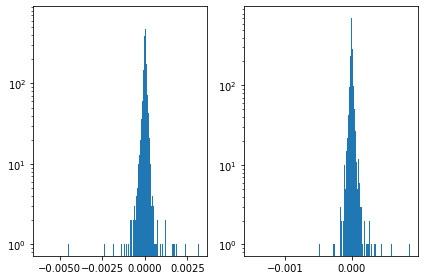

In [4]:
fig, axs = plt.subplots(1, 2, tight_layout=True)

# Create plots of the weighted asset returns
axs[0].hist(x1, bins=300, log=True) # Use log trans since 
axs[1].hist(x2, bins=300, log=True) # since data is highly
plt.show()                          # peaked


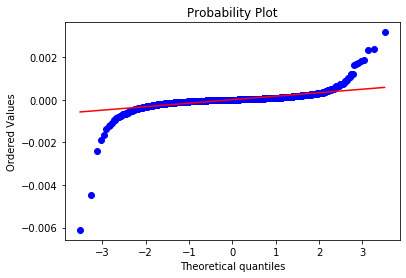

In [5]:
# QQ-plot for asset 1
stats.probplot(x1, plot=plt)
plt.show()


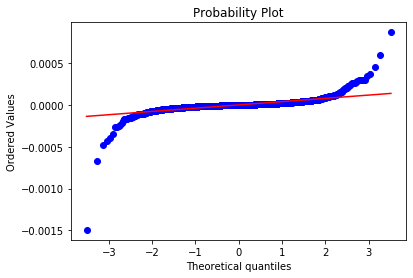

In [6]:
# QQ-plot for asset 2
stats.probplot(x2, plot=plt)
plt.show()


We see remarkably [fat tails](https://seankross.com/2016/02/29/A-Q-Q-Plot-Dissection-Kit.html) in both cases. Next let's compare these plots to the unweighted returns data for these two assets. We first transform the raw data.

In [7]:
# Pivot the raw data since assets are stacked
unweighted_ret = pd.pivot(spdata, 
                          values = ['BIDLO', 'ASKHI', 'VOL', 'RETX'], 
                          index='date', columns = 'PERMNO')
    
# Infers objects; those that can't be inferred are
# converted to `NaN`
unweighted_ret = unweighted_ret.convert_objects(convert_numeric=True)
    
# Replace all missing entries with '0'
unweighted_ret = unweighted_ret.replace('NaN',0)
    
# We're only insterested in returns
unweighted_ret = unweighted_ret['RETX']

# First asset - first in data
x1_raw = unweighted_ret.iloc[:,0]

# Second asset - 370th in data, randomly chosen
x2_raw = unweighted_ret.iloc[:,369]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


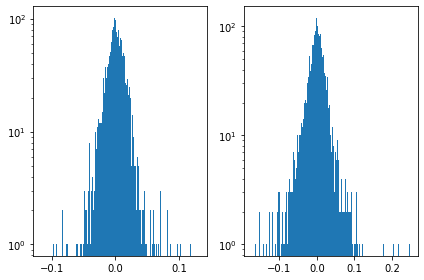

In [8]:
fig, axs = plt.subplots(1, 2, tight_layout=True)

# Create plots of the raw asset returns
axs[0].hist(x1_raw, bins=300, log=True) # Use log trans since 
axs[1].hist(x2_raw, bins=300, log=True) # since data is highly
plt.show()                              # peaked


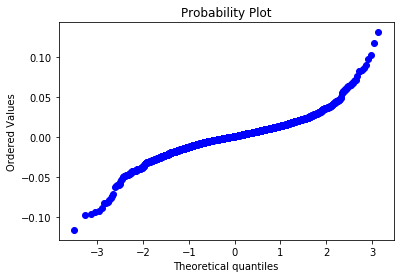

In [9]:
# QQ-plot for asset 1
stats.probplot(x1_raw, plot=plt)
plt.show()


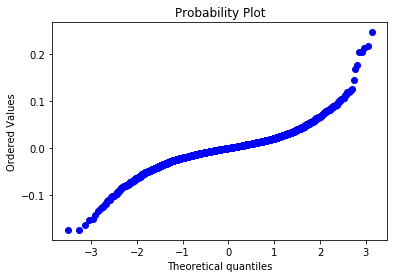

In [10]:
# QQ-plot for asset 2
stats.probplot(x2_raw, plot=plt)
plt.show()


In the unweighted returns, we still see evidence for fat-tails, or [leptokurtosis](https://en.wikipedia.org/wiki/Kurtosis). This is consistent with [previous work](https://www.longin.fr//Recherche_Publications/Articles_pdf/Longin_The_choice_of_the_distribution_of_asset_returns.pdf#page=2), which has found that asset returns often indeed exhibit leptokurtosis.

In light of this we must consider whether we are justified in employing a Gaussian mixture model to estimate the density of data which appears to be non-normal. To answer this question, consider what this data represents. These are the daily returns for an asset over a period of more than twelve years. This period includes both an extremely pronounced economic recession and a long, sustained period of economic growth. It seems likely then that these assets' returns actually contain multiple "regimes", each associated with its own mean and variance. Therefore it makes since to view each asset's return history as a mixture of Gaussians.

To confirm our assumption that asset returns are leptokurtic, we calculate the kurtosis for a sample of the assets in the data.  

In [11]:
# Calculate kurtosis for raw returns data
raw_kurt = pd.DataFrame(stats.kurtosis(
    unweighted_ret, bias=False, nan_policy='omit'), columns={'Kurtosis'})

raw_kurt[:10]

,Kurtosis
0,6.825553
1,10.234459
2,9.393829
3,5.483380
4,12.595756
5,175.202549
6,8.834397
7,8.587304
8,14.583731
9,34.317811


We see that all assets in this sample exhibit kurtoses greater than 0, which [confirms](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) that the sample distributions are fat-tailed. 

We next calculate the kurtosis for the same sample of assets using the weighted returns data.

In [12]:
# Calculate kurtosis for weighted returns data
X_kurt = pd.DataFrame(
    stats.kurtosis(X, bias=False, nan_policy='omit'), columns={'Kurtosis'})

X_kurt[:10]

,Kurtosis
0,207.827455
1,95.925747
2,26.945770
3,180.599143
4,65.253828
5,181.924157
6,364.984546
7,155.453199
8,62.616346
9,870.343376


We see in all cases kurtosis is increased signifigantly by the data transformation. Intuitively this makes sense, since we would expect large returns are associated with large volumes. Indeed, research [provides strong evidence](https://www.cjournal.cz/files/65.pdf) for this intuition.

In our case we weighted the returns data for each asset by the dollar-value traded in that instrument, a transformation which essentially maximizes outliers and minimizes inliers, as seen in the histograms above.

## Dynamic asset correlations

Not only are the returns for each asset associated with multiple regimes, but the correlation between assets is clearly non-constant.

In [13]:
# Correlation between assets using the first 1200 days
corr_matrix_1 = pd.DataFrame(np.corrcoef(X.iloc[:1200,:].T), columns=X.columns)

corr_matrix_1.head()


PERMNO,10104,10107,10138,10145,10516,10623,10696,10909,11308,11403,...,92611,92614,92624,92655,92778,93002,93089,93096,93132,93429
0,1.000000,0.318289,0.361920,0.387020,0.243160,NaN,0.339363,0.170941,0.294044,0.089385,...,NaN,NaN,NaN,0.205125,NaN,NaN,NaN,NaN,NaN,NaN
1,0.318289,1.000000,0.435810,0.338496,0.179704,NaN,0.349383,0.155571,0.341893,0.050365,...,NaN,NaN,NaN,0.143239,NaN,NaN,NaN,NaN,NaN,NaN
2,0.361920,0.435810,1.000000,0.520426,0.285873,NaN,0.488194,0.188603,0.352470,0.137617,...,NaN,NaN,NaN,0.189089,NaN,NaN,NaN,NaN,NaN,NaN
3,0.387020,0.338496,0.520426,1.000000,0.292635,NaN,0.462795,0.176893,0.372460,0.089967,...,NaN,NaN,NaN,0.260053,NaN,NaN,NaN,NaN,NaN,NaN
4,0.243160,0.179704,0.285873,0.292635,1.000000,NaN,0.221538,0.105389,0.264910,0.072102,...,NaN,NaN,NaN,0.150736,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Correlation between assets using the next 1200 days
corr_matrix_2 = pd.DataFrame(np.corrcoef(X.iloc[1200:2400,:].T), columns=X.columns)

corr_matrix_2.head()


PERMNO,10104,10107,10138,10145,10516,10623,10696,10909,11308,11403,...,92611,92614,92624,92655,92778,93002,93089,93096,93132,93429
0,1.000000,0.088739,0.203242,0.176314,0.098402,NaN,0.126675,0.062620,0.035406,0.087129,...,0.086629,0.011925,NaN,0.071391,0.073866,0.065523,0.038870,0.012727,0.099276,0.047625
1,0.088739,1.000000,0.171994,0.198238,0.105657,NaN,0.182473,0.076407,0.108210,0.086355,...,0.111222,0.038374,NaN,0.097059,0.071977,0.095556,0.025867,0.007198,-0.033410,0.093001
2,0.203242,0.171994,1.000000,0.507124,0.340276,NaN,0.432477,0.146871,0.283729,0.272391,...,0.231519,0.056455,NaN,0.201156,0.189649,0.175310,0.102320,0.059348,0.043520,0.145527
3,0.176314,0.198238,0.507124,1.000000,0.323634,NaN,0.449842,0.131344,0.254172,0.207843,...,0.246170,0.062846,NaN,0.215172,0.223421,0.204401,0.117115,0.064267,0.082186,0.125902
4,0.098402,0.105657,0.340276,0.323634,1.000000,NaN,0.303221,0.143740,0.227177,0.123069,...,0.143839,0.046829,NaN,0.197041,0.099754,0.118164,0.084553,0.022039,0.081007,0.054989


`corr_matrix_1` is calculated using the first 1200 days of returns data, and `corr_matrix_2` is calculated using the next 1200 days. We see that the correlations between assets in the second matrix are very different in comparison to their counterparts in the first matrix.

The dynamic nature of the correlations among assets in time implies that these correlations themselves experience regimes. We will attempt to infer these regimes from the data.

# Principal component analysis

A quick inspection of the correlation matrices for the data shows that a certain degree of correlation exists among many assets' returns. This inherent correlation suggests that we should use some decomposition scheme to minimize correlation among the predictors. 

Another reason for decomposition is that less liquid assets are likely to exhibit much greater variance in returns &mdash; or volatility &mdash; than more liquid assets, even when there is no apparent exogeneous cause for price movement. For the purposes of this project, this endogeneous volatility may be viewed as noise which needs to be minimized. Hence the need for decomposition.

Both of these facts suggest that a principal components decomposition of the weighted returns data is appropriate. To perform a principal components decomposition we must provide the algorithm with a parameter `n_components`, the number of components to keep from the decomposition. We use the method of maximum likelihood estimation to determine this value.

Using the [probabilistic PCA model](http://www.miketipping.com/papers/met-mppca.pdf#page=5) we may derive a log-likelihood for our data given the parameters of the model, including the number of principal components retained. We may then use cross-validation to estimate the out-of-sample log-likelihood for a set of PCA models and compare their performance, selecting the model the greatest out of sample log-likelihood.

Since we have no reason to believe that any certain number of components to retain in the model is superior, we use [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV.score) with a uniform distribution for `n_components` from 1 to the `min(n_samples, n_features)` of the data matrix. In this way the grid search method is free to choose any number of components to retain. We use this function since LAPACK, the SVD solver used by [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), is demanding with regards to the dimensionality of the data matrix on which it operates. Because we need to calculate this value on the transformed array in the pipeline we implement this step using `EstimatorSocketCV` from `thermidor`.


In [15]:
def pca_dist(df, proportion=.8):
    '''Creates scipy randint distribution
    with max=min(n_samples, n_features) of
    df.
    
    Parameters
    ----------
    df : array-like
    
    proportion : float, optional default=.8
        Determines the maximum of the range for the distribution.
        Defaults to .8 since 5-fold cross-validation uses at most 
        80 percent of the data.
    
    Returns
    -------
    scipy.stats object
    '''
    n_samples = df.shape[0] * proportion
    
    n_features = df.shape[1]
    
    dist_max = min(n_samples, n_features)
    
    return randint(1, dist_max)


In [16]:
# See:
# https://github.com/rcorrero/thermidor/blob/master/thermidor/classes/estimator_socket_cv.py
decomposer = EstimatorSocketCV(estimator=PCA(), param_name='n_components',
                               dist_func=pca_dist, cross_val=RandomizedSearchCV,
                               cv=5, n_jobs=-1, random_state=0)


# Gaussian mixture model

Once our data has been successfully decomposed, we must then estimate the number of groups contained within the data. To do so, we use a [Gaussian mixture model](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

This model treats the distribution of the daily weighted returns as a mixture of $k$ Gaussian distributions, each with its own covariance matrix and mean. Using the method of [expectation-maximization](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm) the model estimates the means and covariances of the distributions by choosing those values which maximize the log-likelihood of the data \[see [_Elements of Statistical Learning_](https://web.stanford.edu/~hastie/ElemStatLearn/) for more about expectation-maximization and the Gaussian mixture model\].

This algorithm, like the principal components algorithm, yields a log-likelihood value which may be used to compare models with different parameters. We use this log-likelihood to compare models with different values $k$ to find an optimum. This is done using cross-validation.

Once again, we have no prior knowledge of the true number of regimes contained within the data, but we would prefer that $k$ be both large enough to allow for meaniningful segmentation of the data and yet small enough that all clusters are relatively dense, that is, contain many data points. We therefore use [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV.score) with a uniform distribution for $k$ ranging from 1 to 300, approximately one-tenth the number of dates in the data. If the value chosen for $k$ is a boundary value, i.e. the smallest or largest $k$ in the sample of $k$ values, then we must modify our model. If the smallest $k$ is found to be optimal, then we have strong evidence that there is no meaningful clustering of the data possible, and if the largest $k$ is chosen then we need to extend the range for $k$ to include larger values.

To estimate the number of clusters using `GaussianmixtureModel` we create a bespoke class `GMMSocketCV` which inherits from [`EstimatorSocketCV`](https://github.com/rcorrero/thermidor/blob/master/thermidor/classes/estimator_socket_cv.py).

In [17]:
# See:
# https://github.com/rcorrero/thermidor/blob/master/thermidor/classes/estimator_socket_cv.py
class GMMSocketCV(EstimatorSocketCV):
    '''Adds `means_` attribute for use in `returns_pipeline`.
    '''
    def fit(self, X, y=None, **kwargs):
        '''Fits estimator using `cross_val`.
        '''
        # Distribution passed to `cross_val`
        self.dist = {
            self.param_name : self.dist_func(X)
        }
        
        # Create cross-validator object
        self.model_selector = self.cross_val(self.estimator, self.dist,
                                             cv=self.cv, n_jobs=self.n_jobs,
                                             random_state=self.random_state,
                                             verbose=self.verbose)
        
        self.model_selector.fit(X, y, **kwargs)
        
        # Store `best_estimator_`
        self.best_estimator_ = self.model_selector.best_estimator_
        
        # Store `means_` for use in pipeline
        self.means_ = self.best_estimator_.means_
        
        return self
    
    def transform(self, X):
        '''Returns X.
        
        Implemented so that this estimator may be used
        as intermediate step in pipeline.
        '''
        return X
    

This class allows us to use `GaussianMixtureModel` as an intermediate step in a Sci-kit Learn pipeline, something which is not possible otherwise. This class also allows for easy extraction of `means_` from `GaussianMixtureModel` in future steps in the pipeline.

In [18]:
def gmm_dist(df, proportion=.8):
    '''Creates scipy randint distribution
    with max=(n_samples * proportion) of df.
    
    Parameters
    ----------
    df : array-like
    
    Returns
    -------
    scipy.stats object
    '''
    # Determines the maximum of the range for the distribution
    proportion = .1
    
    dist_max = df.shape[0] * proportion
    
    return randint(1, dist_max)


In [19]:
density_estimator = GMMSocketCV(estimator=GaussianMixture(), 
                                      param_name='n_components',
                                      dist_func=gmm_dist,
                                      cross_val=RandomizedSearchCV,
                                      cv=5, n_jobs=-1, random_state=0)


# K-means

Once an appropriate value for $k$ has been found, we need to segment the data space such that the data in any region of the space may be associated with a specific cluster. To do so, we use [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans). 

K-means may be viewed as a kind of "hard" Gaussian mixture model in which the responsibility of a component for a data point is one for the component with mean closest to it, and the responsibility for all other components is zero \[see [_Elements of Statistical Learning_](https://web.stanford.edu/~hastie/ElemStatLearn/) for a more rigorous comparison of Gaussian mixture models and K-means\]. This model is useful in segmenting the data space so that data may be associated with clusters. The clusters may then be analyzed individually to identify similarities in the data.

`KMeans` requires both `n_clusters`, the number of clusters to fit, and `init`, the initial cluster center locations in the data space. In our pipeline we obtain both of these parameters from the optimal Gaussian mixture model selected in the previous step. 

Once the data is segmented we create a dataframe in which each date in the data is associated with a \(numbered\) cluster.

To implement the segmentation step in our pipeline using `KMeans` we create a bespoke class `KMeansSocketCV` which also inherits from `ClustererSocket`. 

In [20]:
# See:
# https://github.com/rcorrero/thermidor/blob/master/thermidor/classes/clusterer_socket.py
class KMeansSocket(ClustererSocket):
    '''Class which allows for passing `means_`
    into `KMeans` from `GaussianMixtureModel`
    [or any other object which has a `means_`
    attribute].
       
    Parameters
    ----------
    pca_name : string
        Name of pipeline step from which `index_` is extracted.
        
    gmm_name : string
            Name of pipeline step from which `means_` is extracted.
            
    labels_ : list of strings, optional default=None
        Labels of each point.
        
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
        - None, to use the default 3-fold cross validation,
        - integer, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.
        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used.
            
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
            
    random_state : int, RandomState instance or None, optional, default=None
        Pseudo random number generator state used for random uniform sampling
        from lists of possible values instead of scipy.stats distributions.
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
            
    verbose : integer
        Controls the verbosity: the higher, the more messages.
    '''
    def __init__(self, pca_name=None, gmm_name=None, labels_=None,
                 cv=3, n_jobs=None, random_state=None, verbose=False):
        self.pca_name = pca_name
        self.gmm_name = gmm_name
        self.labels_ = labels_
        
        self.cv = cv
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        
    def fit(self, X, y=None, **kwargs):
        '''Fits `KMeans` using `means_`
        from `gmm_name` step in pipeline.
        '''
        self.pipeline = returns_pipeline
            
        # Extract `means_` from previous step in pipeline
        self._means = self.pipeline.named_steps[
            self.gmm_name].means_
        
        # Calculate number of clusters
        self.n_clusters = self._means.shape[0]
        
        # Create estimator object
        self.estimator = KMeans(n_clusters=self.n_clusters, 
                                init=self._means, verbose=self.verbose, 
                                random_state=self.random_state, n_jobs=-1)
            
        self.estimator.fit(X)
            
        # Set `labels_` attribute for future steps
        self.labels_ = self.estimator.labels_
            
        return self
    
    def transform(self, X):
        '''Returns X.
            
        Implemented so that this estimator may be used
        as intermediate step in pipeline.
        '''
        # Verify estimator has been fitted
        assert self.labels_ is not None, 'Estimator is not fitted yet.'
        
        # Create dataframe containing dates associated with clusters
        return labeled_data_joiner(X, self.labels_, self.pca_name)


This class allows us to use `means_` from the previous step to initialize the clustering on the transformed weighted returns space.

# Pipeline implementation

Our pipeline consists of five named steps. The first two steps are [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer)s. The first step implements `transform_returns`; the second step implements [`date_extractor`](https://github.com/rcorrero/thermidor/blob/master/thermidor/functions/date_extractor.py) from `thermidor`. The third step implements 'decomposer'; the fourth step `GMMSocketCV`; and the fifth and final step `KMeansSocket`.

In [21]:
def labeled_data_joiner(df, labels, step_name):
    '''Creates a Pandas datafrme associating
    dates with the clusters to which they belong
    
    These clusters should be mutually-exclusive 
    partitions of the data space.
    
    Parameters
    ----------
    df : array-like
    
    labels : 
        Labels of each point
    '''
    # Extract `index_` from 'decomposer'
    dates = returns_pipeline.named_steps[step_name].index_

    # Create dataframe
    labeled_data = pd.DataFrame({'dates': dates, 
                                 'cluster': labels})
    
    return labeled_data

The pipeline is structured such that the first three steps transform the data so that it may be used by the fourth step, `GMMSocketCV`, to select the optimal number of clusters. This value, along with the estimated cluster `means_`, are supplied to the fifth step, `KMeansSocketCV`, for segmentation of the data space. The fourth step simply returns `X`, i.e. the input data array, when `transform` is called on the pipeline. Finally, in the fifth step `labeled_data_joiner` creates a dataframe containing dates and the clusters to which they belong when `transform` is called on `KMeansSocket`.

In [22]:
# ===============================PIPELINE=================================== #

# Pipeline : raw data->dates labeled by cluster
#            membership
returns_pipeline = Pipeline([
    ('preprocessor', 
     FunctionTransformer(func=transform_returns, kw_args={'alpha' : 1.0},
                        validate=False)
    ),
    
    ('date_selector',
     FunctionTransformer(func=date_extractor, 
                         kw_args={'start_date' : 20070101, 
                                  'end_date' : 20180101}, 
                         validate=False)
    ),
    
    # RandomizedSearchCV with PCA and uniform param dist
    ('decomposer',
     decomposer
    ), 
    
    # RandomizedSearchCV with GMM and uniform param dist
    ('density_estimator',
     density_estimator
    ), 
    
    # KMeans with init=GMM.means_
    ('segmenter',
     KMeansSocket(pca_name='decomposer', gmm_name='density_estimator', 
                  cv=5, n_jobs=-1, random_state=0, verbose=10) 
    ),],
    verbose=10
)

# ===============================PIPELINE=================================== #


# Fitting the data

We conclude by fitting `returns_pipeline` on the data, then transforming the data to obtain a Pandas datafrme associating dates with the clusters to which they belong.

In [23]:
results = returns_pipeline.fit_transform(spdata)

results.head()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


[Pipeline] ...... (step 1 of 5) Processing preprocessor, total= 1.8min
[Pipeline] ..... (step 2 of 5) Processing date_selector, total=   0.4s
[Pipeline] ........ (step 3 of 5) Processing decomposer, total=  14.5s
[Pipeline] . (step 4 of 5) Processing density_estimator, total= 7.1min


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


[Pipeline] ......... (step 5 of 5) Processing segmenter, total=   0.3s


,dates,cluster
0,20070103,193
1,20070104,184
2,20070105,120
3,20070108,120
4,20070109,25


In [24]:
results['cluster'].nunique()

196

We see that 'density_estimator' converged to an interior local optimum.

In [25]:
pd.DataFrame(returns_pipeline.named_steps['density_estimator'].model_selector.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,39.275088,8.084099,0.782277,0.114390,173,{'n_components': 173},698.043250,700.260140,701.768663,702.309288,702.342351,700.944234,1.636018,3
1,22.698776,3.827563,0.218641,0.078357,48,{'n_components': 48},697.972549,699.999603,701.433332,702.135186,702.170483,700.741715,1.592569,9
2,39.268614,13.792442,0.596621,0.139212,118,{'n_components': 118},698.031370,700.191331,701.711581,702.303237,702.288906,700.904785,1.630291,6
3,42.636353,6.493906,0.858106,0.111587,193,{'n_components': 193},698.064915,699.967070,701.794602,702.399716,702.396000,700.923929,1.684860,5
4,57.571593,6.006373,1.413904,0.481144,252,{'n_components': 252},698.083161,699.872747,701.875363,702.427298,702.451668,700.941502,1.713115,4
5,41.123506,5.275619,0.715745,0.198404,196,{'n_components': 196},698.088541,700.271743,701.837146,702.412356,702.371592,700.995779,1.648344,1
6,2.531050,0.798068,0.043952,0.009193,10,{'n_components': 10},698.038652,699.810812,700.721808,701.616611,701.835582,700.404176,1.383282,10
7,29.210389,5.303723,0.527719,0.025291,212,{'n_components': 212},698.097922,699.822278,701.808713,702.393864,702.378724,700.899766,1.688688,7
8,33.916793,5.359555,0.605268,0.038104,243,{'n_components': 243},698.069009,700.154265,701.774298,702.448885,702.478420,700.984436,1.684665,2
9,14.513413,5.525443,0.141828,0.079421,88,{'n_components': 88},698.094484,699.736294,701.660454,702.243103,702.234091,700.793165,1.632893,8


In [26]:
returns_pipeline.named_steps['decomposer'].best_estimator_.n_components_

118

'decomposer' also converged to an interior optimum.

In [27]:
pd.DataFrame(returns_pipeline.named_steps['decomposer'].model_selector.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.586388,0.038964,0.087358,0.011440,173,{'n_components': 173},2645.751393,3478.510667,3642.794648,3663.358353,3372.918210,3360.662230,373.258844,8
1,0.328776,0.024337,0.071195,0.016092,48,{'n_components': 48},3020.505832,3458.110956,3578.479676,3534.200656,3420.986617,3402.450055,198.866057,2
2,0.488257,0.064381,0.073576,0.035197,118,{'n_components': 118},2896.864241,3499.315763,3633.235772,3615.363811,3416.932871,3412.340834,269.609316,1
3,0.865544,0.015245,0.095711,0.028548,193,{'n_components': 193},2642.763416,3485.494776,3639.290875,3666.347759,3356.398086,3358.059582,374.773868,9
4,1.369138,0.078269,0.145202,0.033313,324,{'n_components': 324},2782.815085,3460.696684,3673.454159,3696.149230,3223.245252,3367.324096,338.567264,5
5,1.045230,0.081108,0.117069,0.021342,252,{'n_components': 252},2671.924018,3488.460009,3654.820436,3686.176063,3346.777193,3369.639797,369.653124,3
6,0.794813,0.091752,0.085547,0.035533,196,{'n_components': 196},2648.784404,3493.759913,3638.082975,3669.794691,3356.107364,3361.307747,373.438223,7
7,0.619385,0.014269,0.113431,0.013393,360,{'n_components': 360},2765.899970,3427.000640,3682.417387,3709.606421,3152.947890,3347.644749,353.801557,10
8,0.267322,0.034829,0.053388,0.015275,10,{'n_components': 10},3133.083991,3313.671185,3487.968132,3472.161338,3436.535088,3368.659443,132.738313,4
9,0.632351,0.104432,0.058541,0.019148,212,{'n_components': 212},2655.162673,3497.685966,3630.769878,3676.416894,3366.284324,3365.263578,371.305498,6


Because both cross-validation steps found interior optima, we feel confident that the parameter distributions over which the model optimizes are appropriate, and the model does not need to be modified. 

# Complete model

We include the model's code in one cell for reproducibility.

In [28]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

from scipy.stats import randint

# Sci-kit Learn
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# thermidor
from thermidor import EstimatorSocketCV
from thermidor import ClustererSocket
from thermidor import date_extractor


def transform_returns(df, alpha=1.0):
    '''Extracts weighted returns data from
    CRSP raw data.
    
    Parameters
    ----------
    df : array-like
    
    alpha : float, optional default=1.0
        Real number to multiply weighted returns by.
        
    Returns
    -------
    Pandas dataframe containing weighted returns.
    '''
    # Pivot the raw data since assets are stacked
    df = pd.pivot(df, 
                  values = ['BIDLO', 'ASKHI', 'VOL', 'RETX'], 
                  index='date', columns = 'PERMNO'
                 )
    
    # Infers objects; those that can't be inferred are
    # converted to `NaN`
    df = df.convert_objects(convert_numeric=True)
    
    # Replace all missing entries with '0'
    df.replace('NaN',0)
    
    # Functions for `vectorize` to apply elementwise to
    # pairs of elements from columns
    average = lambda x, y : ((x + y) / 2.0)
    
    multiply = lambda x, y : (x * y)
    
    divide = lambda x, y : (x / y)
    
    permnos = df['RETX'].columns.tolist()
    
    for permno in permnos:
        # Step 1 - Calculate midprice
        df[('MIDPRCE', permno)] = np.vectorize(average)(df[('ASKHI', permno)],
                                                        df[('BIDLO', permno)])
        
        # Step 2 - Calculate midprice dollar-value traded
        df[('DLRTRDED', permno)] = np.vectorize(multiply)(df[('MIDPRCE', permno)],
                                                          df[('VOL', permno)])
        
    # Sum total dollar-value traded by day
    df['TTLDLRTRDED'] = df['DLRTRDED'].sum(axis=1)
    
    # Drop indexes containing '0' entries in 'TTLDLRTRDED'
    # These are days with no market activity
    df.drop(df.index[df['TTLDLRTRDED'] == 0], inplace=True)
    
    for permno in permnos:
        # Step 3 - Calculate the percentage of total dollar-value traded
        df[('PRCNTDLRTRDED', permno)] = np.vectorize(divide)(df[('DLRTRDED', permno)], 
                                                             df['TTLDLRTRDED'])
        
        # Step 4 - Calculate weighted return
        df[('WGHTEDRETX', permno)] = alpha * np.vectorize(multiply)(
            df[('PRCNTDLRTRDED', permno)], df[('RETX', permno)])
    
    # Sort dataframe by PERMNO
    df = df.sort_index(axis=1, level=1)
    
    # Only return weighted returns
    X = df['WGHTEDRETX']
    
    return X


def pca_dist(df, proportion=.8):
    '''Creates scipy randint distribution
    with max=min(n_samples, n_features) of
    df.
    
    Parameters
    ----------
    df : array-like
    
    proportion : float, optional default=.8
        Determines the maximum of the range for the distribution.
        Defaults to .8 since 5-fold cross-validation uses at most 
        80 percent of the data.
         
    Returns
    -------
    scipy.stats object
    '''    
    n_samples = df.shape[0] * proportion
    
    n_features = df.shape[1]
    
    dist_max = min(n_samples, n_features)
    
    return randint(1, dist_max)


# See:
# https://github.com/rcorrero/thermidor/blob/master/thermidor/classes/estimator_socket_cv.py
class GMMSocketCV(EstimatorSocketCV):
    '''Adds `means_` attribute for use in `returns_pipeline`.
    '''
    def fit(self, X, y=None, **kwargs):
        '''Fits estimator using `cross_val`.
        '''
        # Distribution passed to `cross_val`
        self.dist = {
            self.param_name : self.dist_func(X)
        }
        
        # Create cross-validator object
        self.model_selector = self.cross_val(self.estimator, self.dist,
                                             cv=self.cv, n_jobs=self.n_jobs,
                                             random_state=self.random_state,
                                             verbose=self.verbose)
        
        self.model_selector.fit(X, y, **kwargs)
        
        # Store `best_estimator_`
        self.best_estimator_ = self.model_selector.best_estimator_
        
        # Store `means_` for use in pipeline
        self.means_ = self.best_estimator_.means_
        
        return self
    
    def transform(self, X):
        '''Returns X.
        
        Implemented so that this estimator may be used
        as intermediate step in pipeline.
        '''
        return X


def gmm_dist(df, proportion=.8):
    '''Creates scipy randint distribution
    with max=(n_samples * proportion) of df.
    
    Parameters
    ----------
    df : array-like
    
    Returns
    -------
    scipy.stats object
    '''
    # Determines the maximum of the range for the distribution
    proportion = .1
    
    dist_max = df.shape[0] * proportion
    
    return randint(1, dist_max)


# See:
# https://github.com/rcorrero/thermidor/blob/master/thermidor/classes/clusterer_socket.py
class KMeansSocket(ClustererSocket):
    '''Class which allows for passing `means_`
    into `KMeans` from `GaussianMixtureModel`
    [or any other object which has a `means_`
    attribute].
       
    Parameters
    ----------
    pca_name : string
        Name of pipeline step from which `index_` is extracted.
        
    gmm_name : string
            Name of pipeline step from which `means_` is extracted.
            
    labels_ : list of strings, optional default=None
        Labels of each point.
        
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
        - None, to use the default 3-fold cross validation,
        - integer, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.
        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used.
            
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
            
    random_state : int, RandomState instance or None, optional, default=None
        Pseudo random number generator state used for random uniform sampling
        from lists of possible values instead of scipy.stats distributions.
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
            
    verbose : integer
        Controls the verbosity: the higher, the more messages.
    '''
    def __init__(self, pca_name=None, gmm_name=None, labels_=None,
                 cv=3, n_jobs=None, random_state=None, verbose=False):
        self.pca_name = pca_name
        self.gmm_name = gmm_name
        self.labels_ = labels_
        
        self.cv = cv
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        
    def fit(self, X, y=None, **kwargs):
        '''Fits `KMeans` using `means_`
        from `gmm_name` step in pipeline.
        '''
        self.pipeline = returns_pipeline
            
        # Extract `means_` from previous step in pipeline
        self._means = self.pipeline.named_steps[
            self.gmm_name].means_
        
        # Calculate number of clusters
        self.n_clusters = self._means.shape[0]
        
        # Create estimator object
        self.estimator = KMeans(n_clusters=self.n_clusters, 
                                init=self._means, verbose=self.verbose, 
                                random_state=self.random_state, n_jobs=-1)
            
        self.estimator.fit(X)
            
        # Set `labels_` attribute for future steps
        self.labels_ = self.estimator.labels_
            
        return self
    
    def transform(self, X):
        '''Returns X.
            
        Implemented so that this estimator may be used
        as intermediate step in pipeline.
        '''
        # Verify estimator has been fitted
        assert self.labels_ is not None, 'Estimator is not fitted yet.'
        
        # Create dataframe containing dates associated with clusters
        return labeled_data_joiner(X, self.labels_, self.pca_name)


def labeled_data_joiner(df, labels, step_name):
    '''Creates a Pandas datafrme associating
    dates with the clusters to which they belong
    
    These clusters should be mutually-exclusive 
    partitions of the data space.
    
    Parameters
    ----------
    df : array-like
    
    labels : 
        Labels of each point
    '''
    # Extract `index_` from 'decomposer'
    dates = returns_pipeline.named_steps[step_name].index_

    # Create dataframe
    labeled_data = pd.DataFrame({'dates': dates, 
                                 'cluster': labels})
    
    return labeled_data


# ===============================PIPELINE=================================== #

# Pipeline : raw data->dates labeled by cluster
#            membership
returns_pipeline = Pipeline([
    ('preprocessor', 
     FunctionTransformer(func=transform_returns, kw_args={'alpha' : 1.0},
                         validate=False)
    ),
    
    ('date_selector',
     FunctionTransformer(func=date_extractor, 
                         kw_args={'start_date' : 20070101, 
                                  'end_date' : 20180101}, 
                         validate=False)
    ),
    
    # RandomizedSearchCV with PCA and uniform param dist
    ('decomposer',
     EstimatorSocketCV(estimator=PCA(), param_name='n_components',
                       dist_func=pca_dist, cross_val=RandomizedSearchCV,
                       cv=5, n_jobs=-1, random_state=0)
    ), 
    
    # RandomizedSearchCV with GMM and uniform param dist
    ('density_estimator',
     GMMSocketCV(estimator=GaussianMixture(), 
                 param_name='n_components',
                 dist_func=gmm_dist,
                 cross_val=RandomizedSearchCV,
                 cv=5, n_jobs=-1, random_state=0)
    ), 
    
    # KMeans with init=GMM.means_
    ('segmenter',
     KMeansSocket(pca_name='decomposer', gmm_name='density_estimator', 
                  cv=5, n_jobs=-1, random_state=0, verbose=10) 
    ),],
    verbose=10
)

# ===============================PIPELINE=================================== #
